Project + Kaggle Challenge to predict number of early (2019-2020) covid-19 cases in Ohio based on a dataset containing twitter data about awareness for various topics, such as politics, health, and disease, as well as demographic variables and deaths. Achieved a 0.90 $R^2$ accuracy score on testing data.

In [20]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, make_scorer

# PART I: Descriptive Analysis

In [19]:
df = pd.read_csv('training_data.csv')
df.head(10)

,county,cases,deaths,date_index_converted,county_data_length,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,...,labor_force_rate,unemployment_rate,median_housing_cost,median_household_earnings,median_worker_earnings,percent_insured,percent_married,poverty_rate,median_property_value,percent_white
0,Richland,0,0,day_10,363,0.000000,0.000000,0.000000,0.000011,0.000151,...,55.5,7.5,675,41877,23210,90.5,48.3,15.6,103700,0.868085
1,Lawrence,119,0,day_105,256,0.000000,0.000000,0.000000,0.000000,0.000000,...,53.5,6.5,655,42874,23510,92.2,49.3,18.6,101500,0.954027
2,Wayne,49,0,day_90,769,0.000076,0.000370,0.006502,0.000039,0.000000,...,64.0,4.0,762,50383,26658,87.2,55.1,13.0,140100,0.950541
3,Fayette,7,0,day_85,36,0.000000,0.000000,0.000000,0.000000,0.000000,...,59.3,6.3,732,40503,25858,91.3,51.8,17.7,108900,0.940054
4,Trumbull,0,0,day_7,554,0.000000,0.000000,0.000000,0.000046,0.000000,...,56.4,5.9,661,43073,25800,91.7,49.1,17.2,101600,0.885724
5,Clinton,182,0,day_112,71,0.000254,0.000529,0.028169,0.000331,0.000000,...,62.4,6.6,781,46787,25751,92.6,52.6,14.7,123700,0.941699
6,Shelby,0,0,day_1,113,0.000000,0.000000,0.000000,0.000000,0.000000,...,68.1,5.3,776,54550,30213,95.5,56.4,8.9,137800,0.942763
7,Tuscarawas,196,0,day_104,276,0.000085,0.000604,0.007246,0.000105,0.000000,...,62.0,4.9,722,45310,25370,90.3,54.2,13.8,117100,0.968173
8,Champaign,0,0,day_50,39,0.000000,0.000000,0.000000,0.000000,0.000000,...,62.5,7.3,814,50974,27550,93.9,55.3,11.1,126700,0.944725
9,Morrow,7,0,day_94,66,0.000178,0.001479,0.015152,0.000128,0.000000,...,64.2,4.3,821,51993,26935,93.8,55.9,9.7,139400,0.972893


### b)

cases                       160.373766
deaths                        2.960840
county_data_length         1318.223177
core_jaccard                  0.000031
core_cosine                   0.000188
                             ...      
percent_insured              92.122572
percent_married              52.210156
poverty_rate                 14.382681
median_property_value    126103.470232
percent_white                 0.919213
Length: 142, dtype: float64


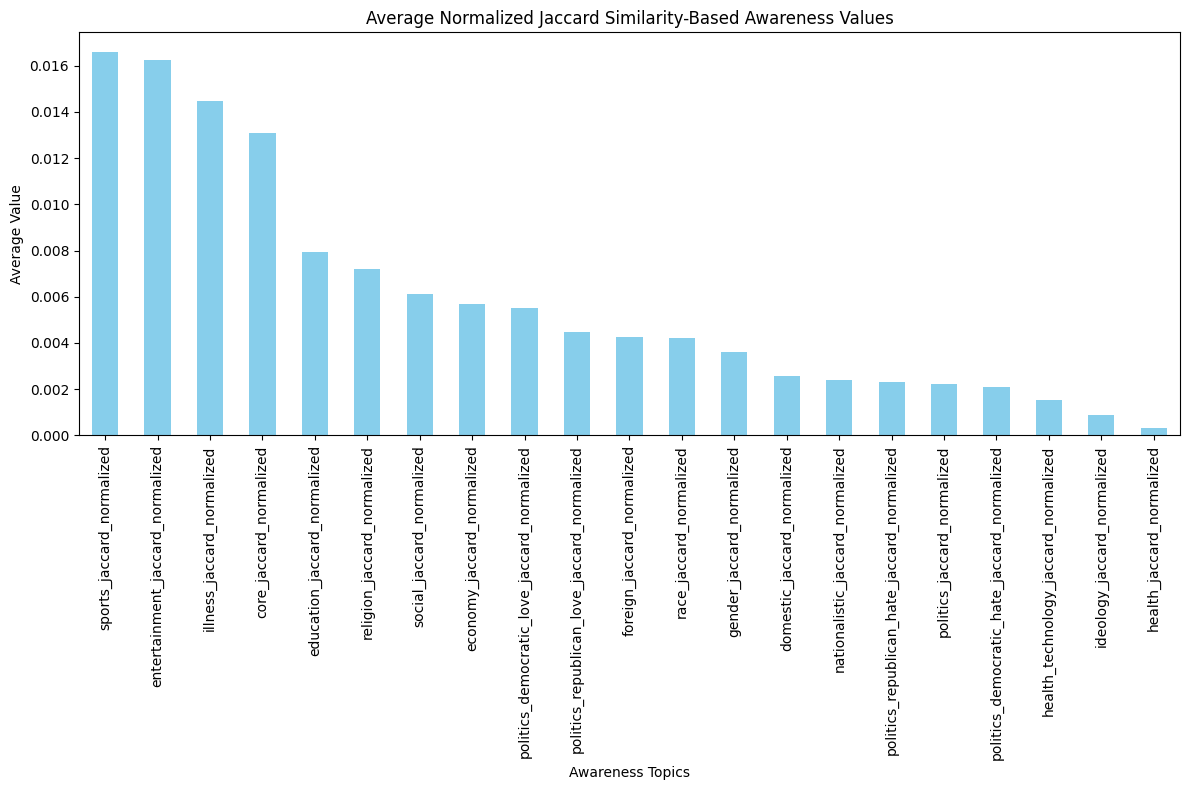

In [23]:
# Calculate the average values for all the topic awareness variables
average_values = df.mean(numeric_only=True)
print(average_values)

# List of jaccard normalized variables
jaccard_variables = [col for col in df.columns if 'jaccard_normalized' in col]

# Calculate the average values for the selected topic awareness variables
average_j = df[jaccard_variables].mean()

# Sort the average values in descending order
average_j_sorted = average_j.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 8))
average_j_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Normalized Jaccard Similarity-Based Awareness Values')
plt.xlabel('Awareness Topics')
plt.ylabel('Average Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### c)

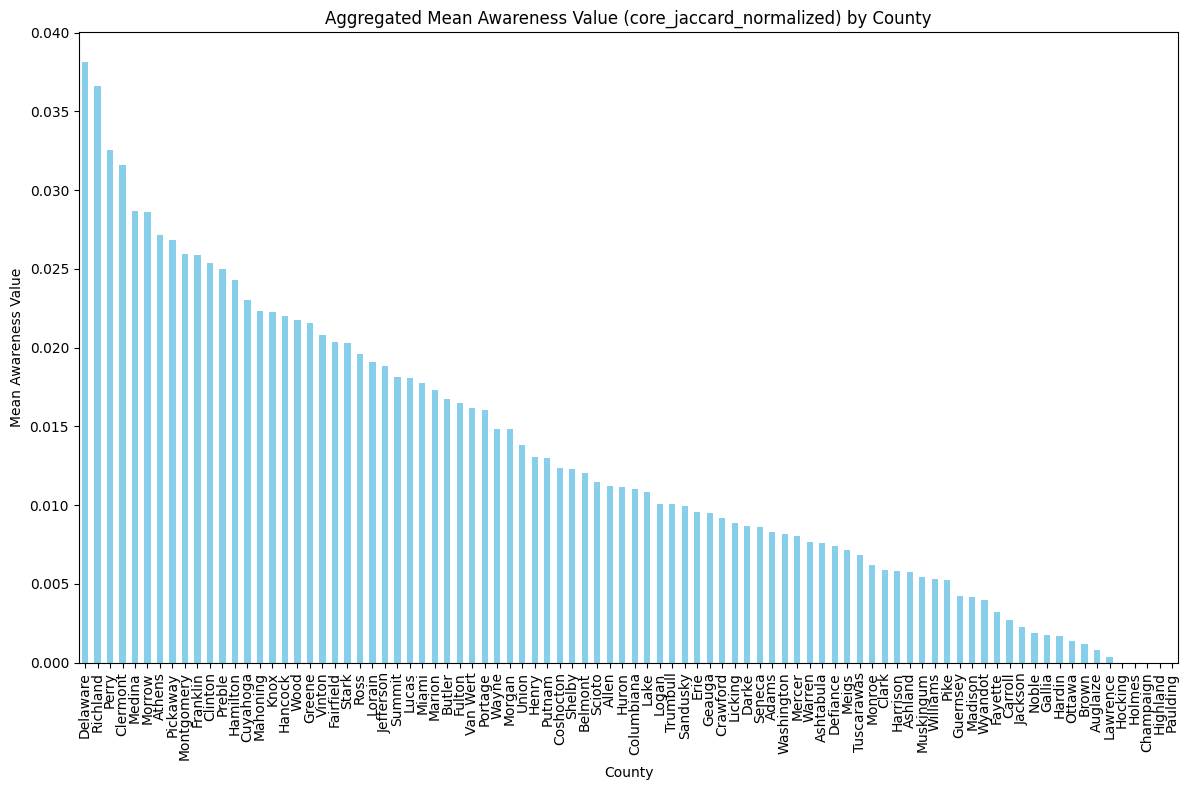

In [24]:
# Group the DataFrame by county and calculate the mean of core_jaccard_normalized
mean_values_by_county = df.groupby('county')['core_jaccard_normalized'].mean()

# Sort mean values in descending order
mean_values_by_county_sorted = mean_values_by_county.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 8))
mean_values_by_county_sorted.plot(kind='bar', color='skyblue')
plt.title('Aggregated Mean Awareness Value (core_jaccard_normalized) by County')
plt.xlabel('County')
plt.ylabel('Mean Awareness Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### d)

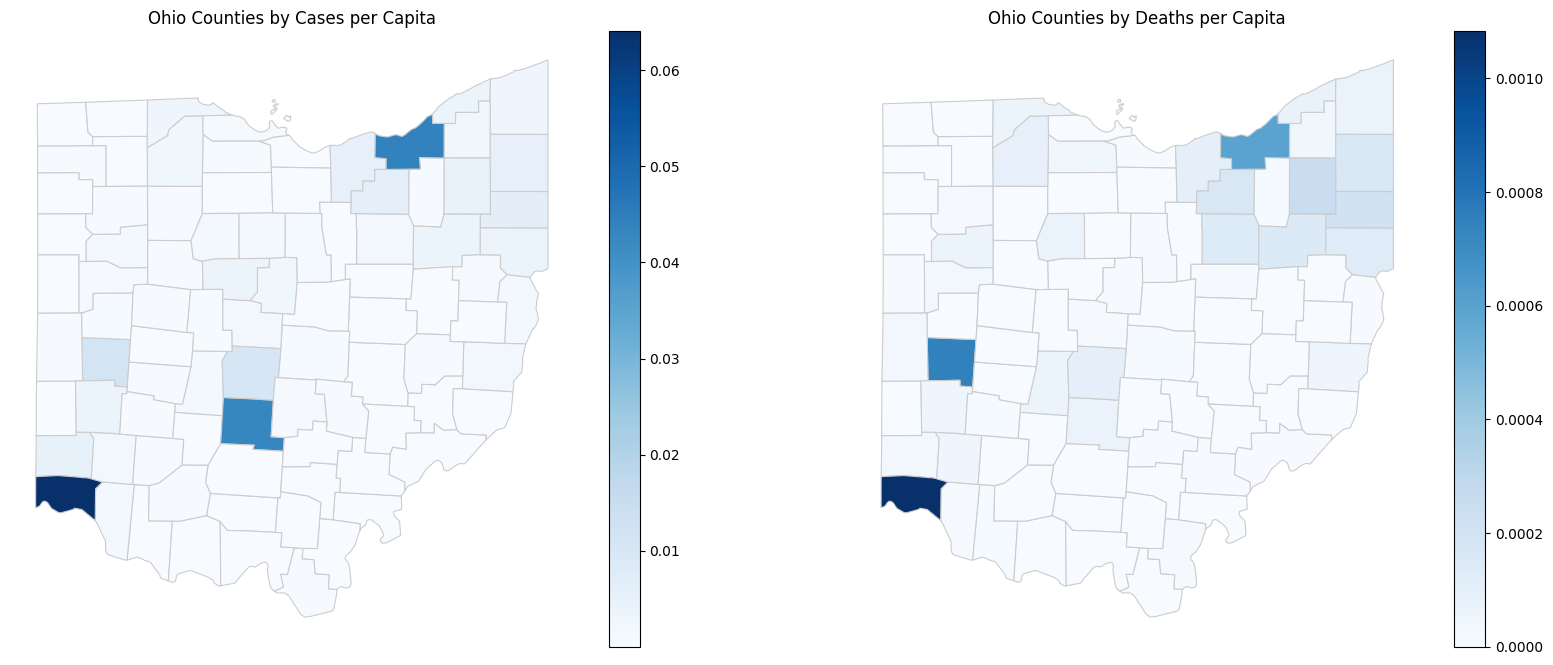

In [29]:
# Geojson shape file found here: https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/data/US-counties.geojson

# Load shapefile for Ohio counties
ohio_counties = gpd.read_file('US-counties.geojson')
ohio_counties = ohio_counties[ohio_counties['STATE']=='39']

# Get averages for counties 
county_avgs = df.groupby('county')[['cases', 'deaths', 'total_pop']].mean().reset_index()
county_avgs['cases_per_capita'] = county_avgs['cases']/df['total_pop']
county_avgs['deaths_per_capita'] = county_avgs['deaths']/df['total_pop']

# Merge with shapefile
ohio_counties = ohio_counties.merge(county_avgs, how='left', left_on='NAME', right_on='county')

# Plot cases per capita
fig, ax1 = plt.subplots(1, 2, figsize=(20, 8))

ohio_counties.plot(column='cases_per_capita', cmap='Blues', linewidth=0.8, ax=ax1[0], edgecolor='0.8', legend=True)
ax1[0].set_title('Ohio Counties by Cases per Capita')
ax1[0].axis('off')

# Plot deaths per capita
ohio_counties.plot(column='deaths_per_capita', cmap='Blues', linewidth=0.8, ax=ax1[1], edgecolor='0.8', legend=True)
ax1[1].set_title('Ohio Counties by Deaths per Capita')
ax1[1].axis('off')

plt.show()

In [31]:
# Top 5s
county_avgs.nlargest(5, 'cases_per_capita')

,county,cases,deaths,total_pop,cases_per_capita,deaths_per_capita
30,Hamilton,930.787879,15.727273,804194.0,0.064157,0.001084
17,Cuyahoga,1838.600000,24.942857,1263189.0,0.044110,0.000598
64,Pickaway,1791.500000,3.000000,56515.0,0.042980,0.000072
54,Miami,223.461538,14.307692,103517.0,0.011660,0.000747
24,Franklin,1724.026316,16.105263,1215761.0,0.010500,0.000098


In [30]:
# Top 5s

county_avgs.nlargest(5, 'deaths_per_capita')

,county,cases,deaths,total_pop,cases_per_capita,deaths_per_capita
30,Hamilton,930.787879,15.727273,804194.0,0.064157,0.001084
54,Miami,223.461538,14.307692,103517.0,0.011660,0.000747
17,Cuyahoga,1838.600000,24.942857,1263189.0,0.044110,0.000598
66,Portage,270.729730,14.918919,161897.0,0.004594,0.000253
49,Mahoning,589.689655,19.241379,234550.0,0.006361,0.000208


### e)

C:\Users\tarun\AppData\Local\Temp\ipykernel_13700\371493159.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_j['date_index_val'] = df['date_index_converted'].apply(lambda x: int(x[4:]))


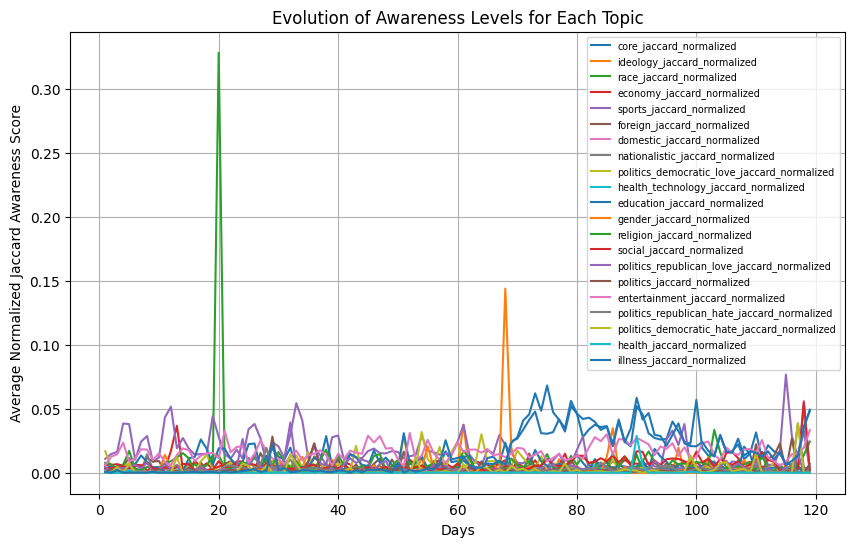

In [36]:
# Get Jaccard Normalized Variables

jaccard_variables = [col for col in df.columns if 'jaccard_normalized' in col]
df_j = df[jaccard_variables]

# Make date index numeric
df_j['date_index_val'] = df['date_index_converted'].apply(lambda x: int(x[4:]))

# Calculate average scores for each day

average_scores_by_day = df_j.groupby('date_index_val')[jaccard_variables].mean()


# Plot the line chart
plt.figure(figsize=(10, 6))
for column in average_scores_by_day.columns:
    plt.plot(average_scores_by_day.index, average_scores_by_day[column], label=column)

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Average Normalized Jaccard Awareness Score')
plt.title('Evolution of Awareness Levels for Each Topic')

plt.legend(fontsize='x-small', loc='upper right')
plt.grid(True)

# Show plot
plt.show()


In [34]:
df_j

,core_jaccard_normalized,ideology_jaccard_normalized,race_jaccard_normalized,economy_jaccard_normalized,sports_jaccard_normalized,foreign_jaccard_normalized,domestic_jaccard_normalized,nationalistic_jaccard_normalized,politics_democratic_love_jaccard_normalized,health_technology_jaccard_normalized,...,gender_jaccard_normalized,religion_jaccard_normalized,social_jaccard_normalized,politics_republican_love_jaccard_normalized,politics_jaccard_normalized,entertainment_jaccard_normalized,politics_republican_hate_jaccard_normalized,politics_democratic_hate_jaccard_normalized,health_jaccard_normalized,illness_jaccard_normalized
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.005499,0.0,0.021079,0.000000,...,0.000000,0.000000,0.002632,0.010518,0.018491,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.000000,0.007589,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016406,0.000000,0.085540,0.000000,0.0,0.0,0.000000
2,0.032428,0.0,0.0,0.002623,0.002544,0.000000,0.007849,0.0,0.000000,0.000000,...,0.000000,0.005979,0.009071,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033722
3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.333693,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.006867,0.021430,0.000000,0.004465,0.0,0.000000,0.000000,...,0.000000,0.000000,0.010763,0.000000,0.000000,0.061277,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,0.040149,0.0,0.0,0.003621,0.004167,0.003463,0.001798,0.0,0.001384,0.002305,...,0.011539,0.005198,0.009706,0.025584,0.001343,0.028415,0.002774,0.0,0.0,0.061331
3137,0.000000,0.0,0.0,0.000000,0.141461,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.071506,0.000000,0.0,0.0,0.000000
3138,0.005448,0.0,0.0,0.008745,0.004262,0.000000,0.000543,0.0,0.000000,0.000000,...,0.000000,0.009818,0.002131,0.000000,0.001490,0.010769,0.000000,0.0,0.0,0.005602
3139,0.000000,0.0,0.0,0.000000,0.027492,0.000000,0.010399,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


# PART II: Modeling

In [6]:
# Read Data
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

# Formate Day Index value
train['date_index_val'] = train['date_index_converted'].apply(lambda x: int(x[4:]))
test['date_index_val'] = test['date_index_converted'].apply(lambda x: int(x[4:]))

# One Hot Encoding counties
train = pd.concat([train, pd.get_dummies(train['county'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['county'])], axis=1)

In [7]:
# Add Vaccination Data (Only run once)
# Source: https://data.cincinnati.com/covid-19-vaccine-tracker/ohio/39/ 

vacc = pd.read_excel('C19_Vacc.xlsx')

# Fill NaNs and rename
vacc = vacc.ffill().rename(columns = {'People Vaccinated with at least One Dose' : 'Vacc_1_Dose', 'People Fully Vaccinated':'Fully_Vaccinated'})

# Even or Odd
vacc['Type'] = vacc.groupby('Area').cumcount() % 2
vacc['Type'] = vacc['Type'].replace({0: 'tot', 1: 'rate'})

# Format
vacc = vacc.pivot(index='Area', columns='Type', values=['Population', 'Vacc_1_Dose', 'Fully_Vaccinated'])
vacc.columns = [f'{col}_{Type}' for col, Type in vacc.columns]
vacc=vacc.reset_index()

counties_df = pd.DataFrame({'county': train['county'].unique()})

vacc=vacc.rename(columns={'Area':'county'})
vacc['county']=vacc['county'].apply(lambda x: x[:-7])
vacc2 =  counties_df.merge(vacc, how='left', on='county').drop(['Population_tot', 'Population_rate'], axis=1)

# Merge
train=train.merge(vacc2, how='left', on = 'county')
test=test.merge(vacc2, how='left', on = 'county')


In [8]:
# Create X and y
y_train = train.iloc[:,1]
X_train = train.drop(['date_index_converted', 'cases', 'county'], axis=1)
X_test = test.drop(['date_index_converted', 'index', 'county'], axis=1)

X_train.head(10)

,deaths,county_data_length,core_jaccard,core_cosine,core_intersection,social_jaccard,politics_jaccard,politics_democratic_love_jaccard,nationalistic_jaccard,politics_republican_hate_jaccard,...,Warren,Washington,Wayne,Williams,Wood,Wyandot,Vacc_1_Dose_rate,Vacc_1_Dose_tot,Fully_Vaccinated_rate,Fully_Vaccinated_tot
0,0,363,0.000000,0.000000,0.000000,0.000011,0.000151,0.000053,0.0,0.000000,...,False,False,False,False,False,False,0.4772,57898.0,0.4492,54495.0
1,0,256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,False,False,False,False,False,False,0.5692,34504.0,0.5082,30806.0
2,0,769,0.000076,0.000370,0.006502,0.000039,0.000000,0.000000,0.0,0.000000,...,False,False,True,False,False,False,0.4879,56699.0,0.4608,53543.0
3,0,36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,False,False,False,False,False,False,0.4793,13730.0,0.4486,12851.0
4,0,554,0.000000,0.000000,0.000000,0.000046,0.000000,0.000000,0.0,0.000000,...,False,False,False,False,False,False,0.5656,114127.0,0.5282,106582.0
5,0,71,0.000254,0.000529,0.028169,0.000331,0.000000,0.000000,0.0,0.000000,...,False,False,False,False,False,False,0.5032,21081.0,0.4722,19782.0
6,0,113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,False,False,False,False,False,False,0.3853,18802.0,0.3636,17743.0
7,0,276,0.000085,0.000604,0.007246,0.000105,0.000000,0.000000,0.0,0.000091,...,False,False,False,False,False,False,0.4711,43591.0,0.4467,41328.0
8,0,39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,False,False,False,False,False,False,0.4652,18079.0,0.4396,17085.0
9,0,66,0.000178,0.001479,0.015152,0.000128,0.000000,0.000000,0.0,0.000000,...,False,False,False,False,False,False,0.4492,15711.0,0.4264,14915.0


In [9]:
# Model
reg = GradientBoostingRegressor(
    learning_rate=0.252991836, max_depth=3, n_estimators=373, random_state=0, subsample=0.9
)

reg.fit(X_train, y_train)
p=reg.predict(X_test)
p

# Cross validation testing
# scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2')
# print(scores)
# print(np.mean(scores))

array([  4.60881534, 349.26582266,  -4.40647679, ...,   2.5632968 ,
       544.54570943, -11.61613956])

In [16]:

# Get feature importances
feature_importance = reg.feature_importances_

feature_importance_dict = dict(zip(X_train.columns, feature_importance))

# Sort
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

sorted_feature_importance

{'deaths': 0.5459185087724493,
 'Pickaway': 0.15709178527237608,
 'percent_25_34': 0.10215704878430909,
 'total_pop': 0.06505064819419945,
 'Vacc_1_Dose_tot': 0.031262178377526824,
 'Marion': 0.020105116754530274,
 'county_data_length': 0.018327424855115015,
 'percent_white': 0.015477997299026413,
 'gender_intersection': 0.0097158076785945,
 'date_index_val': 0.007929842885101932,
 'illness_jaccard': 0.005662632323514825,
 'core_intersection_normalized': 0.00284090712950749,
 'illness_intersection_normalized': 0.0021471052976823166,
 'illness_intersection': 0.0021086119185645346,
 'core_cosine_normalized': 0.002076057893843217,
 'Vacc_1_Dose_rate': 0.0013567697374033626,
 'economy_jaccard_normalized': 0.0006957953369936661,
 'politics_democratic_love_intersection': 0.0006184036813669912,
 'Fully_Vaccinated_tot': 0.0005954590064193875,
 'health_technology_cosine_normalized': 0.0005601495198905911,
 'politics_republican_love_intersection_normalized': 0.0004970305442877356,
 'poverty_rate

In [ ]:
# Bayesian Optimization
# Step One: optimize learning rate, any others with n_estimators =100
# Step Two: Shown Currently, optimize n_estimators
# Not run because it takes 15+ minutes

# Define the search space for hyperparameters
search_spaces = {
    # 'max_depth': (2, 4),
    # 'learning_rate': (0.01, 0.3),
    # 'subsample': (0.7, 1.0),
    # 'min_samples_split': (2,5),
    # 'min_samples_leaf': (1,5)
    
    'n_estimators': (100, 500)

}


model = GradientBoostingRegressor(random_state =0,
                                learning_rate=0.08190022655571282,
                                min_samples_leaf=3,
                                min_samples_split=3,
                                subsample = 0.9107589752772703
                                )

scoring = make_scorer(r2_score)

# Perform Bayesian optimization for hyperparameter tuning
opt = BayesSearchCV(
    model,
    search_spaces,
    n_iter=30,  # Number of parameter settings that are sampled
    cv=4,  # Number of cross-validation folds
    random_state=42,
    scoring=scoring
)

# Fit the optimizer
opt.fit(X_train, y_train)

# Get the best hyperparameters and results
print("Best hyperparameters:", opt.best_params_)
print("Best score:", opt.best_score_)


# Output after both steps
# Best hyperparameters: OrderedDict([('learning_rate', 0.25299183638035316), ('max_depth', 4), ('subsample', 1.0)])
# Best score: 0.9000053287582153

# OrderedDict([('n_estimators', 373)])

In [18]:
# Make result df

p=np.maximum(0,p)

result = pd.DataFrame({'Index': test['index'], 'Cases': p})
result.head(15)


,Index,Cases
0,0,4.608815
1,1,349.265823
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.780815
6,6,0.000000
7,7,10.182649
8,8,0.000000
9,9,2.113593


In [ ]:
# result.to_csv('submission_GBOPT.csv', index=False)